# Short Time Fourier Transfer

* [Exploring the Short-Time Fourier Transform: Analyzing Time-Varying Audio Signals](https://medium.com/@ongzhixuan/exploring-the-short-time-fourier-transform-analyzing-time-varying-audio-signals-98157d1b9a12)

> ### Wideband Analysis (Short Window)
> With a short window, the STFT offers **higher time resolution**, allowing you to capture rapid changes in the audio signal. This is particularly useful for analyzing transient or rapidly evolving sounds, such as speech or percussive instruments. However, a short window results in **lower frequency resolution** (as number of dimensions (= samples in window) is small), which can make it difficult to distinguish between closely spaced frequency components.
>
> ### Narrowband Analysis (Long Window)
> A long window provides **higher frequency resolution**, enabling you to **identify small frequency differences** in the audio signal. This can be beneficial when analyzing steady-state sounds, like sustained musical notes or constant background noise. However, a long window reduces time resolution, making it less suitable for capturing rapidly changing events in the audio signal.
>
> ### Position of the Windows (Overlap)
> The amount of overlap between consecutive windows can impact the quality of the STFT analysis. **Overlapping windows can help reduce the loss of information at the edges of the windows**, providing a smoother and more continuous representation of the time-frequency characteristics of the audio signal. The degree of overlap depends on the specific application, but **typical values range from 50% to 75%**. However, increased overlap may also result in **higher computational complexity**, as more windows need to be processed.

In [1]:
from IPython.display import (
    Audio, 
    display
)
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Data

In [2]:
data, sampling_rate = librosa.load("./data/jfk.flac")
N = num_total_samples = data.shape[0]

print(f"sampling_rate:[{sampling_rate}], duration:[{data.shape[0] / 22500}] seconds") 
display(Audio(data=data, rate=sampling_rate))

sampling_rate:[22050], duration:[10.78] seconds


# Sound Wave


# Audio Wave (Time Series)

Amplitude of the signal on the y-axis and time along the x-axis

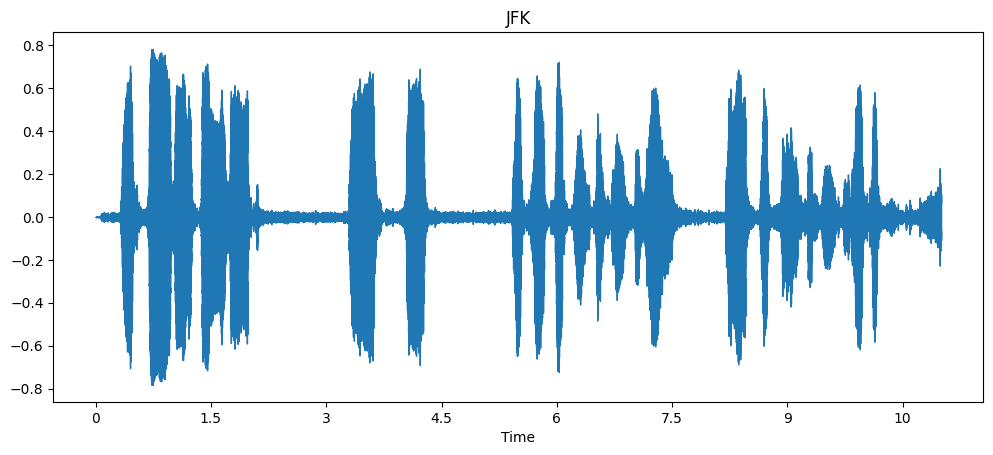

In [3]:
plt.figure().set_figwidth(12)
plt.title("JFK")
librosa.display.waveshow(y=data, sr=sampling_rate)

# Frequency Spectrum

The frequency values are on the x-axis, usually plotted on a logarithmic scale, while their amplitudes are on the y-axis.

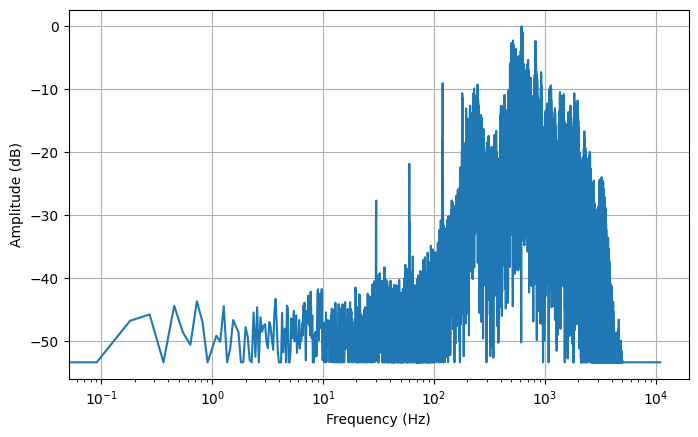

In [4]:
# dft_input = data[:sampling_rate]  # First 1 second
dft_input = data

# calculate the DFT
# window = np.hanning(len(dft_input))
# windowed_input = dft_input * window
# dft = np.fft.rfft(windowed_input, norm="backward")
dft = np.fft.rfft(dft_input, norm="forward")

# Taking the magnitude with np.abs(dft) extracts the amplitude information from the spectrogram
amplitude = np.abs(dft)
# get the amplitude spectrum in decibels
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(8)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid()
plt.xscale("log")

# Short-Time Fourier Transform (STFT)

## Split the audio data into ```N``` frames of size ```L```.

In [5]:
L = window_size = 1024    # Number of samples in the shoft-time frome
S = slide_size = 512
index_to_sample_window: int = int(1.5 * sampling_rate / slide_size)  # at 1.5 sec of the audio

<img src="image/short_time_ft_windowing.png" align="left" width=500/>

In [6]:
def sliding_windows_on_1d_array(
        x: np.ndarray, window_size: int, slide_size: int
) -> np.ndarray:
    """Apply a sliding windows on a 1D array to create a (x-rows, d-columns) array.
    Truncate the trailing items that do not fit into the windows.

    Args:
        x: 1D array to apply the sliding windows.
        window_size: size of window to apply
        slide_size: step side to slide the window

    Returns: numpy array of shape (num_rows, window_size) where num_rows = ((x.size - window_size) // slide_size) + 1
    """
    assert 0 < window_size < x.size,\
        f"expected 0 < window_size < x.size:[{x.size}], got [{window_size}]."
    assert 0 < slide_size < x.size, \
        f"expected 0 < slide_size < x.size:[{x.size}], got [{slide_size}]."

    x = x.reshape(-1)
    num_rows = ((x.size - window_size) // slide_size) + 1
    item_size: int = x.strides[0]               # item size of an element in 1D array x.
    return np.lib.stride_tricks.as_strided(
        x,
        shape=(num_rows, window_size),          # result shape
        strides=(
            slide_size * item_size,             # stride[0] in the result shape (row size)
            item_size                           # stride[1] in the result shape (col size)
        )
    )

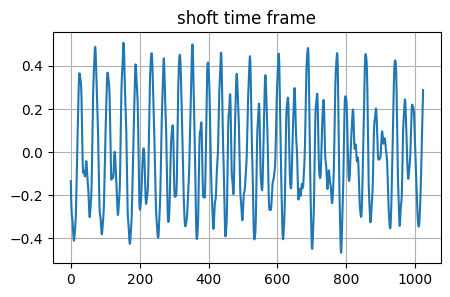

In [7]:
frames: np.ndarray = sliding_windows_on_1d_array(
    x=data,
    window_size=window_size,
    slide_size=slide_size
)

plt.figure(figsize=(5,3))
plt.title("shoft time frame")
plt.grid()
plt.plot(frames[index_to_sample_window])

## Applly Window Function

* [numpy.hamming](https://numpy.org/doc/stable/reference/generated/numpy.hamming.html)

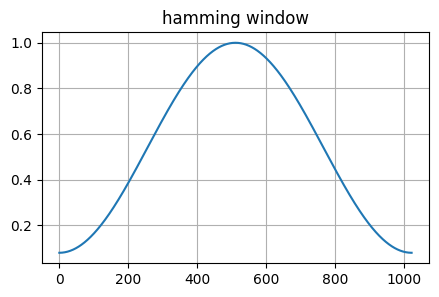

In [8]:
window_array = np.hamming(M=window_size)

plt.figure(figsize=(5,3))
plt.title("hamming window")
plt.grid()
plt.plot(window_array)

In [9]:
windows = frames * window_array
windows.shape

(472, 1024)

### Example windowed result

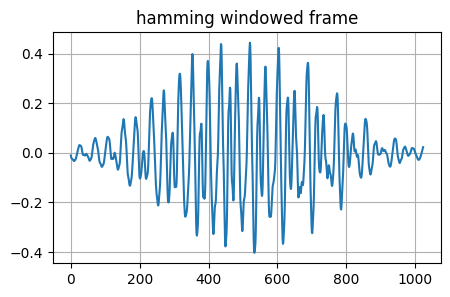

In [10]:
plt.figure(figsize=(5,3))
plt.grid()
plt.title("hamming windowed frame")
plt.plot(windows[index_to_sample_window])

### FFT on example window


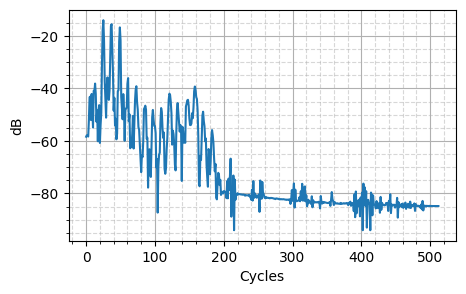

In [11]:
A = 2 * np.abs(np.fft.rfft(windows[index_to_sample_window])) / np.sum(window_array)
A_db = librosa.amplitude_to_db(A)
plt.figure(figsize=(5,3))
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.ylabel("dB")
plt.xlabel("Cycles")
plt.plot(np.linspace(0, len(A_db), num=len(A_db), endpoint=False), A_db)

## FFT on Windows

Normalize with the ```sum(window)``` to restore the energy (as per Parseval's Theorem) lost by applying the window.

In [12]:
# Transpose because librosa expects STFT array of frequency per row.
stft_transformed = np.fft.rfft(windows, norm="backward").T   # Do not normalize here
magnitudes = np.abs(stft_transformed)

# Normalize Fourier Coefficients by restoring the power lost by the window (Perseval's Theorem)
# https://dsp.stackexchange.com/a/49186/73490
amplitudes = 2 * magnitudes / np.sum(window_array) # / len(window_array)

# Convert to dB.
dB = librosa.amplitude_to_db(amplitudes)

### Sample STFT window in dB

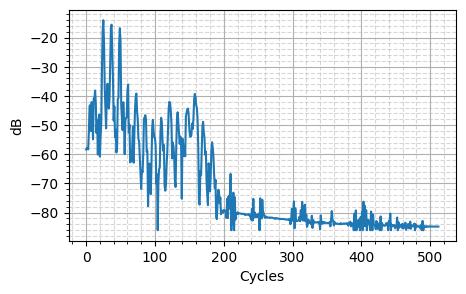

In [14]:
_db = dB.T[index_to_sample_window]
plt.figure(figsize=(5,3))
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.ylabel("dB")
plt.xlabel("Cycles")
plt.plot(np.linspace(0, len(_db), num=len(_db), endpoint=False), _db)

## Spectrogram

dB.mean(): -76.22359215546294


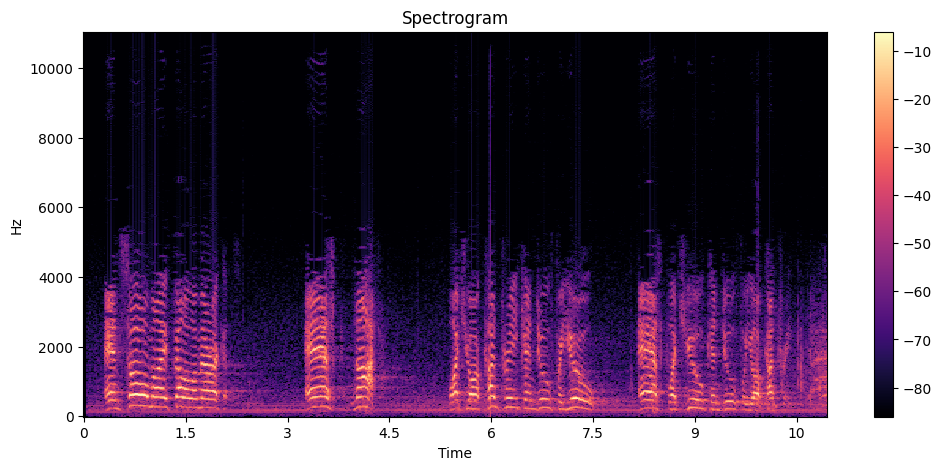

In [15]:
print(f"dB.mean(): {dB.mean()}")

plt.figure(figsize=(12,5))
librosa.display.specshow(
    # log_spectrogram, 
    dB,
    sr=sampling_rate, 
    hop_length=slide_size, 
    x_axis="time", 
    y_axis="linear"
)
# plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.colorbar()
plt.show()

---
# SFTF (librosa and normalized)

Normalize with the ```sum(window)``` to restore the energy (as per Parseval's Theorem) lost by applying the window.

In [16]:
D = librosa.stft(data, n_fft=window_size, win_length=window_size, hop_length=slide_size, window=window_array)
S_dB = librosa.amplitude_to_db(2 * np.abs(D) / np.sum(window_array))

### Sample STFT (librosa) window in dB

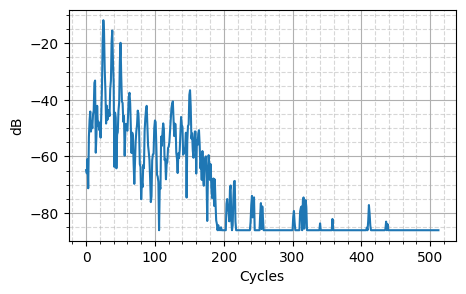

In [17]:
_s_db = S_dB.T[index_to_sample_window]
plt.figure(figsize=(5,3))
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.ylabel("dB")
plt.xlabel("Cycles")
plt.plot(np.linspace(0, len(_s_db), num=len(_s_db), endpoint=False), _s_db)

## Spectrogram

librosa S_dB.mean(): -76.23786926269531


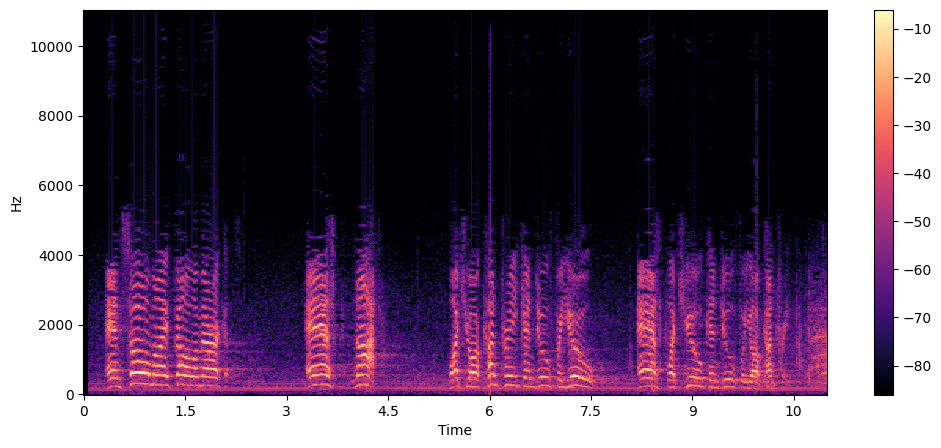

In [18]:
print(f"librosa S_dB.mean(): {S_dB.mean()}")
plt.figure(figsize=(12,5))
librosa.display.specshow(
    S_dB,
    sr=sampling_rate,
    hop_length=slide_size,
    x_axis="time", 
    y_axis="linear"
)
plt.colorbar()